In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
import bokeh.plotting as bp
import plotly.graph_objs as go
from langdetect import detect
from sklearn.manifold import TSNE
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS
from collections import Counter
from gensim.models.word2vec import Word2Vec
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer
from yellowbrick.text.freqdist import FreqDistVisualizer
from yellowbrick.style import set_palette
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.plotting import figure, show, output_notebook
tqdm.pandas()

%matplotlib inline
warnings.filterwarnings("ignore")

/home/dickyalsyah/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/dickyalsyah/anaconda3/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning:

The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version



In [2]:
nyc = pd.read_csv('http://data.insideairbnb.com/united-states/ny/new-york-city/2020-06-08/data/reviews.csv.gz')

In [3]:
nyc.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,2060,158,2008-09-22,2865,Thom,"very nice neighborhood,close enough to ""A"" tra..."
1,2595,17857,2009-11-21,50679,Jean,Notre séjour de trois nuits.\r\nNous avons app...
2,2595,19176,2009-12-05,53267,Cate,Great experience.
3,2595,19760,2009-12-10,38960,Anita,I've stayed with my friend at the Midtown Cast...
4,2595,34320,2010-04-09,71130,Kai-Uwe,"We've been staying here for about 9 nights, en..."


In [4]:
nyc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1182158 entries, 0 to 1182157
Data columns (total 6 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   listing_id     1182158 non-null  int64 
 1   id             1182158 non-null  int64 
 2   date           1182158 non-null  object
 3   reviewer_id    1182158 non-null  int64 
 4   reviewer_name  1182148 non-null  object
 5   comments       1181435 non-null  object
dtypes: int64(3), object(3)
memory usage: 54.1+ MB


# EDA for Rule Based Sentiment Analysis

In [5]:
nyc_rb = pd.read_hdf('newyork_reviews.h5', 'newyork_reviews')

In [6]:
nyc_rb.sample(5)

,listing_id,id,date,reviewer_id,reviewer_name,comments,clean_comments,polarity,sentiment,comment_length,comments_meaningful,polarity_meaningful,sentiment_meaningful,comment_meaningful_length
856781,20968166,231500142,2018-02-01,152255179,Mario,"Lovely place very clean, really enjoyed my stay","lovely place very clean, really enjoyed my stay",0.8922,Positive,8,lovely place clean enjoy stay,0.8658,Positive,5
288091,3897387,80948075,2016-06-20,13806325,Ulrike,Vicki and David are great hosts. It was a plea...,vicki and david are great hosts. it was a plea...,0.9674,Positive,62,vicki david great host pleasure stay beautyful...,0.9674,Positive,23
917625,22382863,437953241,2019-04-15,248616565,Rita,"Great place, clean, quiet with modern amenitie...","great place, clean, quiet with modern amenitie...",0.2247,Neutral,63,great place clean quiet modern amenity neighbo...,0.9360,Positive,29
879173,21475999,570421681,2019-11-29,117064033,Richie,It's okay,it is okay,0.2263,Neutral,3,okay,0.2263,Neutral,1
840914,20479960,340975283,2018-10-25,100128135,Rocío,Nice Near JFK,nice near jfk,0.4215,Neutral,3,nice near jfk,0.4215,Neutral,3


In [7]:
nyc_rb.describe()

,listing_id,id,reviewer_id,polarity,comment_length,polarity_meaningful,comment_meaningful_length
count,1.225808e+06,1.225808e+06,1.225808e+06,1.225808e+06,1.225808e+06,1.225808e+06,1.225808e+06
mean,1.469608e+07,3.172167e+08,8.841829e+07,7.282727e-01,4.987482e+01,7.156050e-01,2.513462e+01
std,1.136470e+07,1.887290e+08,8.360054e+07,3.851840e-01,5.049055e+01,3.851022e-01,2.639298e+01
min,2.060000e+03,1.580000e+02,1.000000e+00,-9.990000e-01,0.000000e+00,-9.990000e-01,0.000000e+00
25%,4.241486e+06,1.519558e+08,1.976680e+07,6.750000e-01,1.700000e+01,6.369000e-01,9.000000e+00
50%,1.367480e+07,3.183435e+08,5.916348e+07,9.012000e-01,3.600000e+01,8.885000e-01,1.800000e+01
75%,2.244863e+07,4.903654e+08,1.401616e+08,9.606000e-01,6.500000e+01,9.545000e-01,3.200000e+01
max,4.332728e+07,6.242377e+08,3.455615e+08,9.997000e-01,1.378000e+03,9.994000e-01,1.074000e+03


Plotting the histogram of review intensities reveals the following peculiarities:

* huge asymmetry between positive and negative reviews, 200+ k of them (or almost 50%) are close to maximally positive (polarity > 0.5);
* prominent peak of ~100k 'neutral' reviews.

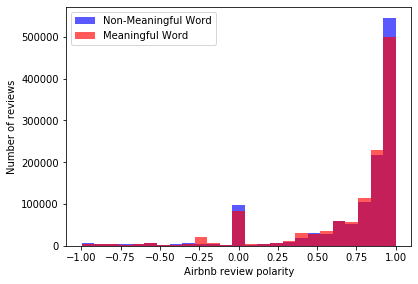

In [8]:
plt.hist(nyc_rb.polarity, bins = 25, color='b', alpha=0.65)
plt.hist(nyc_rb.polarity_meaningful, bins = 25, color='r', alpha=0.65)
plt.legend(['Non-Meaningful Word', 'Meaningful Word'])
plt.xlabel('Airbnb review polarity')
plt.ylabel('Number of reviews')
plt.subplots_adjust(left = 0.15, right = 0.95, top = 0.95, bottom=0.12)
plt.savefig('airbnb_NYC_reviews_polarity.png')

Importantly, very small fraction (< 5%) of all reviews of our interest are negative:

In [9]:
(nyc_rb['polarity_meaningful'].values < -0.05).mean(),\
(nyc_rb['polarity'].values < -0.05).mean()

(0.0508480936655659, 0.039995660005482096)

Let us look on their distribution in more details:

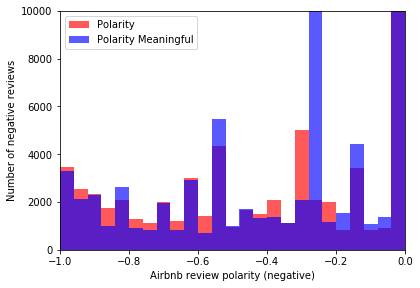

In [10]:
plt.hist(nyc_rb.polarity, bins=50, color='r', alpha=0.65)
plt.hist(nyc_rb.polarity_meaningful, bins=50, color='b', alpha=0.65)
plt.legend(['Polarity', 'Polarity Meaningful'])
plt.xlim([-1.00, 0.00])
plt.ylim([0, 10000])
plt.xlabel('Airbnb review polarity (negative)')
plt.ylabel('Number of negative reviews')
plt.subplots_adjust(left=0.15, right=0.95, top=0.95, bottom=0.12)
plt.savefig('airbnb_NYC_reviews_negative_polarity.png')

As we see, the negative review structure from meaningful word and which is not in Newyork some broad and narrow peaks (such as very negative reviews with polarity < -0.8) are much more pronounced.

In [11]:
(nyc_rb['polarity_meaningful'].values < -0.8).mean(),\
(nyc_rb['polarity'].values < -0.8).mean()

(0.009262461984258546, 0.009947724276558809)

In [12]:
def show_most_common_duplicates(df, top_number=3):
    '''
    Shows several most common duplicates together with their occurence frequency
    
    Args:
        df (pandas dataframe): dataframe that contains ['polarity'] column
        top_number (int, default = 3): number of most common duplicates to show
    
    Returns:
        val_freq_list (list): sorted list that contains the top value and the corresponding frequency
    
    '''
    val = []
    res1 = list(Counter(df['polarity'].values).most_common(top_number))
    res2 = list(Counter(df['polarity_meaningful'].values).most_common(top_number))
    val_freq_list1 = [(i[0], i[1]/df.shape[0]) for i in res1]
    val_freq_list2 = [(i[0], i[1]/df.shape[0]) for i in res2]
    val.append(val_freq_list1)
    val.append(val_freq_list2)
    return val

In [13]:
show_most_common_duplicates(nyc_rb)

[[(0.0, 0.07924976831608213),
  (0.6249, 0.016224400558651927),
  (0.6588, 0.008923909780324488)],
 [(0.0, 0.06583494315586128),
  (0.6249, 0.029200331536423322),
  (-0.25, 0.014450060694660176)]]

As we see, for all scenario the top unique review polarity is 0.0. Also, there is a large variations between meaningful word for its apparent frequency - while for non meaningful word it is only 6,5%, for meaningful word it is as much as 7.9%.

Look closer for reviews with polarity 0.0:

In [14]:
def zero_technical_reviews(df, polarity, comments):
    '''
    Returns the fraction of "technical" reviews (staring from "The host canceled" or
    "The reservation was canceled") of zero polarity
    
    Args:
        df (pandas dataframe): dataframe that contacts columns ['comments'] and ['polarity']
    
    Returns:
        zero_polarity_fraction (float): fraction of "technical" reviews of zero polarity
    '''
    res1 = df[df.polarity == 0.0].comments.map(lambda s: s.startswith('The host canceled')).sum()
    res2 = df[df.polarity == 0.0].comments.map(lambda s: s.startswith('The reservation was canceled')).sum()
    zero_polarity_fraction = (res1+res2)/df.shape[0]
    
    return zero_polarity_fraction

zero_technical_reviews(nyc_rb, nyc_rb['polarity'], nyc_rb['clean_comments']), \
zero_technical_reviews(nyc_rb, nyc_rb['polarity_meaningful'], nyc_rb['comments_meaningful'])

(0.013731351076188114, 0.013731351076188114)

Note also that although most of such technical messages are identified with score 0.0, some of them are not:

In [15]:
def non_zero_technical_reviews(df, polarity, comments):
    '''
    Returns the fraction of "technical" reviews (staring from "The host canceled" or
    "The reservation was canceled") of zero polarity
    
    Args:
        df (pandas dataframe): dataframe that contacts columns ['comments'] and ['polarity']
    
    Returns:
        zero_polarity_fraction (float): fraction of "technical" reviews of zero polarity
    '''
    res1 = df[df.polarity != 0.0].comments.map(lambda s: s.startswith('The host canceled')).sum()
    res2 = df[df.polarity != 0.0].comments.map(lambda s: s.startswith('The reservation was canceled')).sum()
    non_zero_polarity_fraction = (res1+res2)/df.shape[0]
    
    return non_zero_polarity_fraction

non_zero_technical_reviews(nyc_rb, nyc_rb['polarity'], nyc_rb['clean_comments']), \
non_zero_technical_reviews(nyc_rb, nyc_rb['polarity_meaningful'], nyc_rb['comments_meaningful'])

(5.221046036573427e-05, 5.221046036573427e-05)

Okay, we have same value for both polarity. What about very negative reviews? First, look into the dataset:

In [16]:
nyc_rb[nyc_rb.polarity < -0.8].comments_meaningful

122        la padrona di casa stata precisissimo nelle co...
145        wir haben sieben tage bei lisa roxanne ihrer f...
148        wir haben nachte lisas unterkunft verbracht si...
244        die auf den ersten blick einfach eingerichtete...
258        das apartment befindet sich stock des hauses d...
                                 ...                        
1226332    place complete mess picture misleading close s...
1226380    not mind location airbnb rent life dangerous t...
1226387    bad experience airbnb history tell host arrive...
1226432    firstly arrive find guest room book tell host ...
1226441    not able check host unresponsive attempt reach...
Name: comments_meaningful, Length: 12194, dtype: object

Here, in addition to misclassified reviews in non-english, are some reviews in English with different (positive, negative or neutral) polarity that can also be interpreted as the model misinterpretation.

Finally, let us investigate the most positive reviews:

In [17]:
nyc_rb[nyc_rb.polarity > 0.9].comments_meaningful

3          stay friend midtown castle day lovely place bi...
4          stay night enjoy center city sleep short way m...
5          wonderful stay jennifer charming apartment org...
6          hi great compliment jennifer host midtown cast...
7          jennifer friendly helpful place exactly advert...
                                 ...                        
1226547    great place stay family young child space pack...
1226548    love love love place super clean spacious priv...
1226549    wonderful place perfect location place recentl...
1226552    photo not place justice place beautiful homey ...
1226553    nice airbnb stay place clean worth stay recomm...
Name: comments_meaningful, Length: 615617, dtype: object

In [19]:
%%time

def language_detection(text):
    try:
        return detect(text)
    except:
        return None
    
nyc_rb['language'] = nyc_rb['comments'].progress_apply(language_detection)


100%|██████████| 1225808/1225808 [1:33:47<00:00, 217.82it/s]

CPU times: user 1h 32min 59s, sys: 1min 16s, total: 1h 34min 16s
Wall time: 1h 33min 47s


In [20]:
nyc_rb['language'].value_counts().head(10)

en       1077861
fr         43683
es         40756
de         14581
it          7265
pt          6254
zh-cn       4883
ko          4589
ro          3658
nl          3392
Name: language, dtype: int64

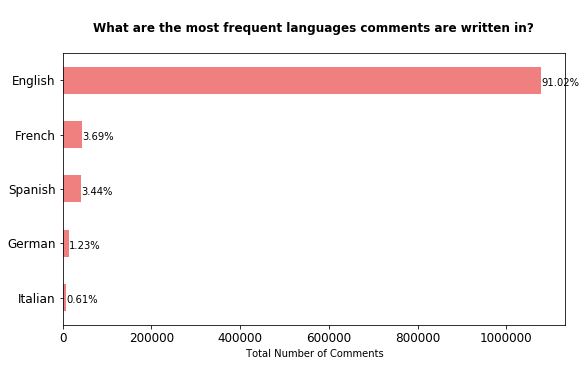

In [21]:
# visualizing the comments' languages b) neat and clean
ax = nyc_rb['language'].value_counts().head(5).plot(kind='barh', figsize=(9,5), color="lightcoral", 
                                             fontsize=12);

ax.set_title("\nWhat are the most frequent languages comments are written in?\n", 
             fontsize=12, fontweight='bold')
ax.set_xlabel(" Total Number of Comments", fontsize=10)
ax.set_yticklabels(['English', 'French', 'Spanish', 'German','Italian'])

# create a list to collect the plt.patches data
totals = []
# find the ind. values and append to list
for i in ax.patches:
    totals.append(i.get_width())
# get total
total = sum(totals)

# set individual bar labels using above list
for i in ax.patches:
    ax.text(x=i.get_width(), y=i.get_y()+.35, 
            s=str(round((i.get_width()/total)*100, 2))+'%', 
            fontsize=10, color='black')

# invert for largest on top 
ax.invert_yaxis()

In [22]:
nyc_en = nyc_rb[(nyc_rb['language']=='en')]

In [27]:
nyc_en.sentiment_meaningful.value_counts()

Positive    971987
Neutral      99017
Negative      6857
Name: sentiment_meaningful, dtype: int64

In [140]:
time_series = nyc_rb.copy()
time_series.index = time_series['date']

grouper = time_series.groupby(['sentiment_meaningful', pd.Grouper(key='date', freq='M')]).id.count()
result = grouper.unstack('sentiment_meaningful').fillna(0)

In [144]:
init_notebook_mode(connected=True)

trace0 = go.Scatter(
    x = result.index,
    y = result['Positive'],
    name = 'Positive',
    opacity=0.8,
    mode='lines',
    line=dict(width=0.5, color='rgb(131, 90, 241)'),
    stackgroup='one'
)

trace1 = go.Scatter(
    x = result.index,
    y = result['Negative'],
    name = 'Negative',
    opacity=0.8,
    mode='lines',
    line=dict(width=0.5, color='rgb(255, 50, 50)'),
    stackgroup='two'
)    
trace2 = go.Scatter(
    x = result.index,
    y = result['Neutral'],
    name = 'Neutral',
    opacity=0.8,
    mode='lines',
    line=dict(width=0.5, color='rgb(184, 247, 212)'),
    stackgroup='three'
)

data = [trace0, trace1, trace2]

iplot(data)

## Visualize Word

In this section, we will create three word clouds using the cleaned text. We use all words in the cleaned text, the positive words based on our own sentiment analysis, and the negative words based on our own sentiment analysis for the  word cloud.

In [31]:
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='black',
        stopwords=stopwords,
        max_words = 500,
        max_font_size = 40, 
        scale = 3,
).generate(str(data))

    fig = plt.figure(1, figsize = (15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()

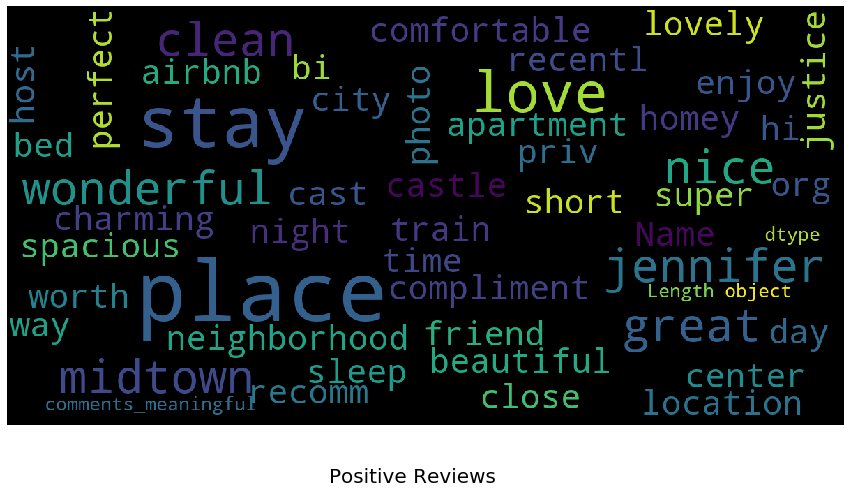

In [33]:
show_wordcloud(nyc_en[nyc_en['sentiment_meaningful'] == 'Positive']['comments_meaningful'], title ='Positive Reviews')

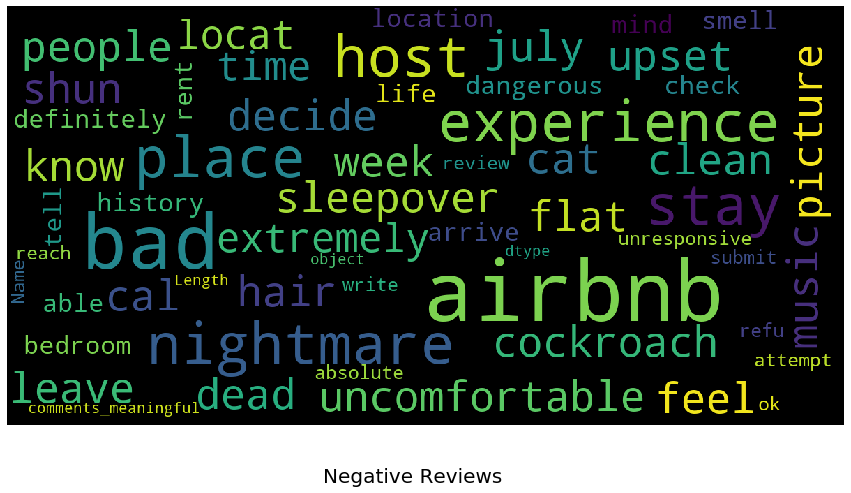

In [32]:
show_wordcloud(nyc_en[nyc_en['sentiment_meaningful'] == 'Negative']['comments_meaningful'], title ='Negative Reviews')

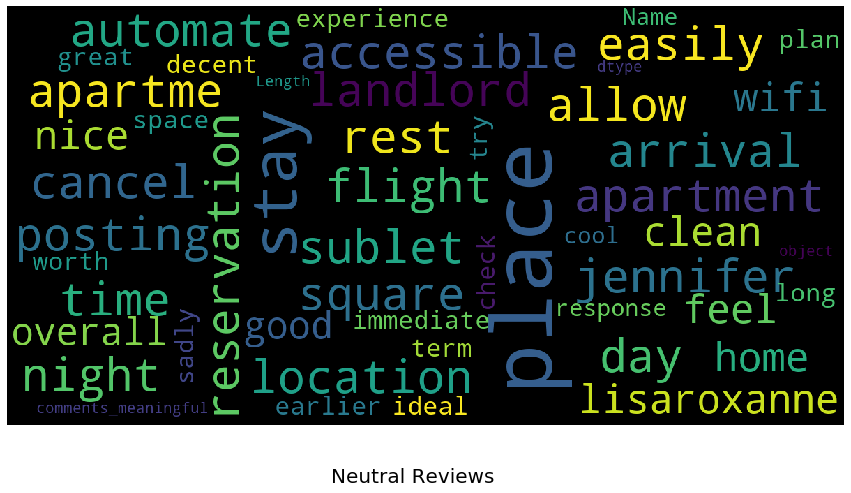

In [34]:
show_wordcloud(nyc_en[nyc_en['sentiment_meaningful'] == 'Neutral']['comments_meaningful'], title ='Neutral Reviews')

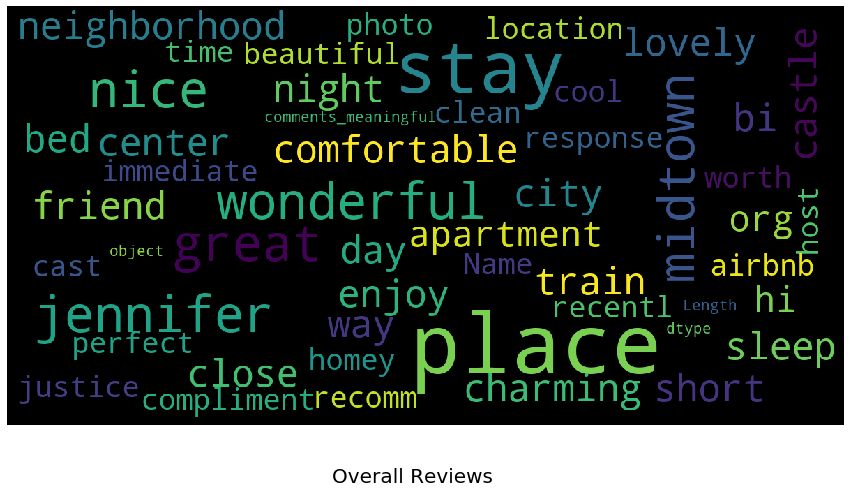

In [37]:
show_wordcloud(nyc_en['comments_meaningful'], title ='Overall Reviews')

## Frequency Distribution

Another method for visually exploring text is with frequency distributions. In the context of a text corpus, such a distribution tells us the prevalence of certain words. Here we use the Yellowbrick library.

In [68]:
pos_comments = (nyc_en[nyc_en['sentiment_meaningful']=='Positive']['comments_meaningful']).tolist()
neg_comments = (nyc_en[nyc_en['sentiment_meaningful']=='Negative']['comments_meaningful']).tolist()
neu_comments = (nyc_en[nyc_en['sentiment_meaningful']=='Neutral']['comments_meaningful']).tolist()

In [69]:
def most_freq_word(text, n, title):
    # vectorizing text
    vectorizer = CountVectorizer(stop_words='english')
    docs = vectorizer.fit_transform(text)
    features = vectorizer.get_feature_names()

    # preparing the plot
    set_palette('pastel')
    plt.figure(figsize=(18,8))
    plt.title('The Top 30 most frequent words used in {} comments\n'.format(title), fontweight='bold')

    # instantiating and fitting the FreqDistVisualizer, plotting the top 30 most frequent terms
    visualizer = FreqDistVisualizer(features = features, n = n)
    visualizer.fit(docs)
    visualizer.poof;

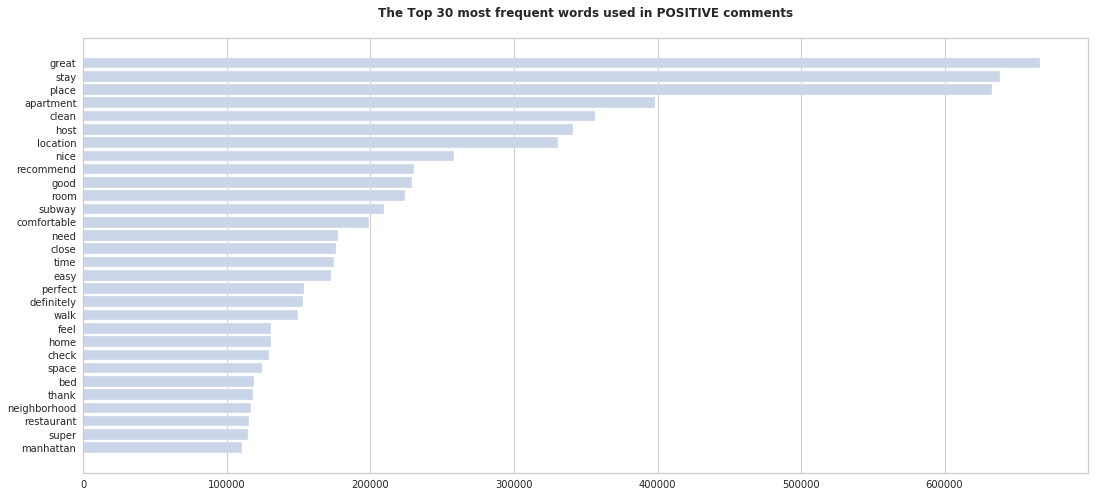

In [70]:
most_freq_word(pos_comments, 30, 'POSITIVE')

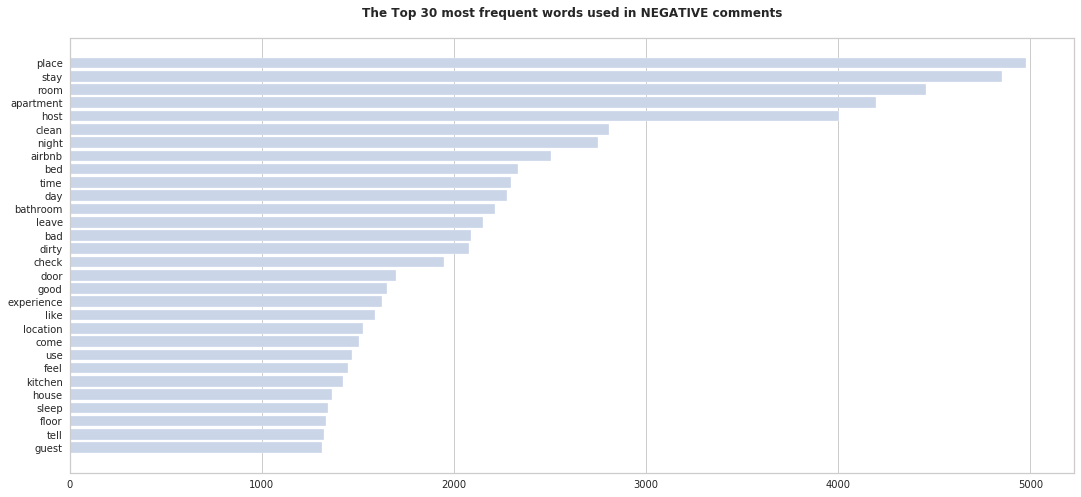

In [71]:
most_freq_word(neg_comments, 30, 'NEGATIVE')

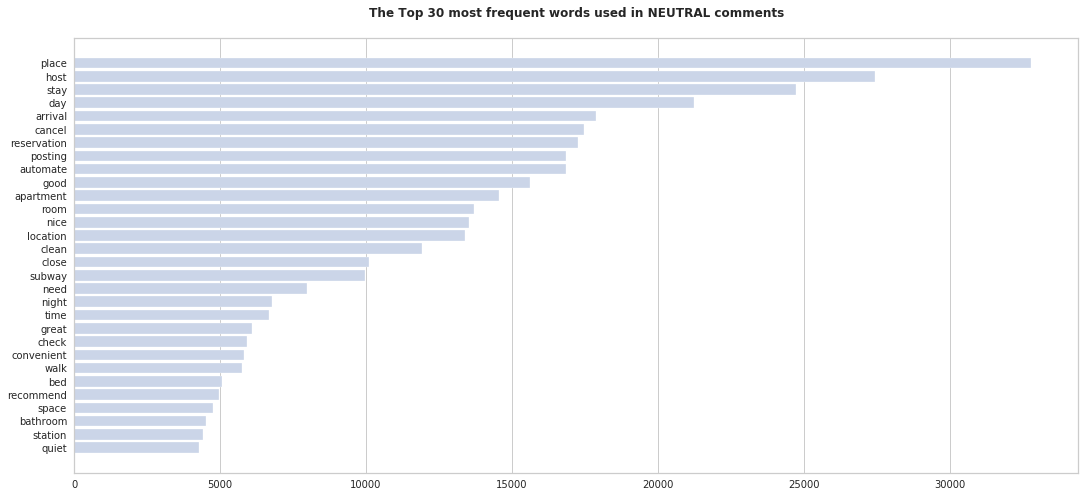

In [72]:
most_freq_word(neu_comments, 30, 'NEUTRAL')

Okay, because we've seen reviews in various languages using detect language. But I have noticed, this package is not entirely accurate and there are many that should be misplaced. So we will not separate reviews into various languages. As natural at first, and to get the best results during classification, we separate our data to make it look more balanced. Look for the next.

# EDA for Data Splitting

In [38]:
nyc_reviews = pd.read_hdf('newyork_reviews_split.h5', 'newyork_reviews_split')

In [39]:
nyc_reviews.describe()

,listing_id,id,reviewer_id,polarity,comment_length,polarity_meaningful,comment_meaningful_length,target
count,1.055750e+05,1.055750e+05,1.055750e+05,105575.000000,105575.000000,105575.000000,105575.000000,105575.000000
mean,1.475059e+07,3.230667e+08,9.636505e+07,0.244572,54.262875,0.189593,34.895648,1.136718
std,1.138634e+07,1.868574e+08,8.506943e+07,0.647436,61.279459,0.654306,41.437514,0.776271
min,2.595000e+03,2.261000e+03,5.600000e+01,-0.999000,0.000000,-0.999000,0.000000,0.000000
25%,4.274595e+06,1.603597e+08,2.493696e+07,-0.025800,15.000000,-0.371300,9.000000,1.000000
50%,1.365729e+07,3.241908e+08,6.941215e+07,0.400300,37.000000,0.296000,21.000000,1.000000
75%,2.254528e+07,4.974579e+08,1.523381e+08,0.893200,71.000000,0.868900,45.000000,2.000000
max,4.332044e+07,6.241639e+08,3.451161e+08,0.999200,1025.000000,0.998800,881.000000,2.000000


We have a sentiment classification from vader. We decided to follow the compound values from their github, which are:

1. positive sentiment : (compound score >= 0.05)
2. neutral sentiment : (compound score > -0.05) and (compound score < 0.05)
3. negative sentiment : (compound score <= -0.05)

Source : https://github.com/cjhutto/vaderSentiment

In [25]:
nyc_reviews.sample(5)


,listing_id,id,date,reviewer_id,reviewer_name,comments,clean_comments,polarity,sentiment,comment_length,comments_meaningful,polarity_meaningful,sentiment_meaningful,comment_meaningful_length,target
877852,21451138,244346421,2018-03-18,178401169,David,Nichts zu beanstanden! Ein komplettes Airbnb H...,nichts zu beanstanden! ein komplettes airbnb h...,-0.6876,Negative,36,nichts zu beanstanden ein komplettes airbnb ha...,-0.8126,Negative,36,0
83190,453094,457191505,2019-05-23,15773100,Hanna & Etele,"Great location, clean apartment, and a good host!","great location, clean apartment, and a good host!",0.8748,Positive,8,great location clean apartment good host,0.8658,Positive,6,2
71034,296361,442015052,2019-04-22,235956718,Tim,"As advertised. Simple room, but great value an...","as advertised. simple room, but great value an...",0.9293,Positive,18,advertise simple room great value min walk sub...,0.8519,Positive,10,2
341001,4950807,34666253,2015-06-10,34232775,Isabelle,Not recommended.\r\nCommunication with the hos...,not recommended. communication with the host w...,-0.9227,Negative,179,not recommend communication host unacceptably ...,-0.8507,Negative,80,0
1024557,27552582,545586828,2019-10-12,131154763,Francesco,"Appartamento piccolo ed essenziale, in un'otti...","appartamento piccolo ed essenziale, in un'otti...",0.0000,Neutral,7,appartamento piccolo ed essenziale un ottima p...,0.0000,Neutral,7,1


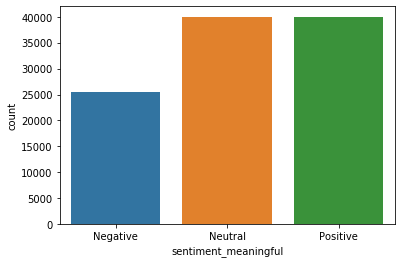

In [26]:
sns.countplot(nyc_reviews['sentiment_meaningful'], data = nyc_reviews)

The data is seems to be imbalanced, but it seems reflecting the real world situation

## Plotting the word length vs Sentiment

<Figure size 576x360 with 0 Axes>

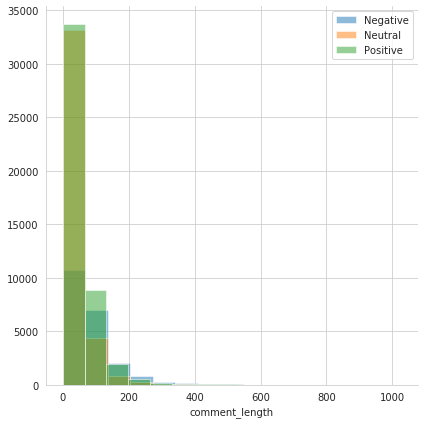

In [27]:
plt.figure(figsize = (8,5))
sns.set_style(style = 'whitegrid')
g = sns.FacetGrid(nyc_reviews, hue = 'sentiment', height = 6)
g = g.map(plt.hist, 'comment_length', bins = 15, alpha = 0.5 )
plt.legend()

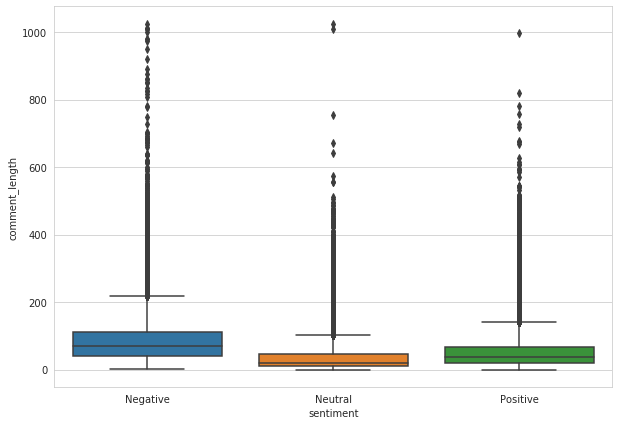

In [28]:
plt.figure(figsize = (10,7))
sns.set_style(style ='whitegrid')
sns.boxplot(data = nyc_reviews, y = 'comment_length', x = 'sentiment')

<Figure size 576x360 with 0 Axes>

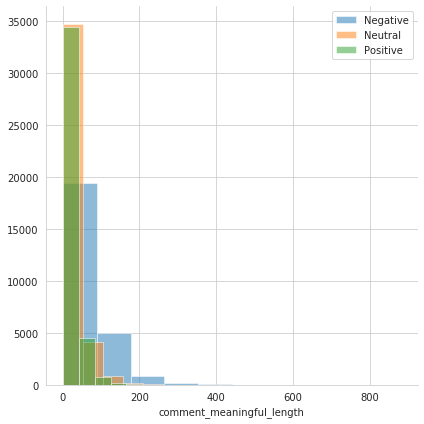

In [29]:
plt.figure(figsize = (8,5))
sns.set_style(style = 'whitegrid')
g = sns.FacetGrid(nyc_reviews, hue = 'sentiment_meaningful', height = 6)
g = g.map(plt.hist, 'comment_meaningful_length', bins = 10, alpha = 0.5 )
plt.legend()

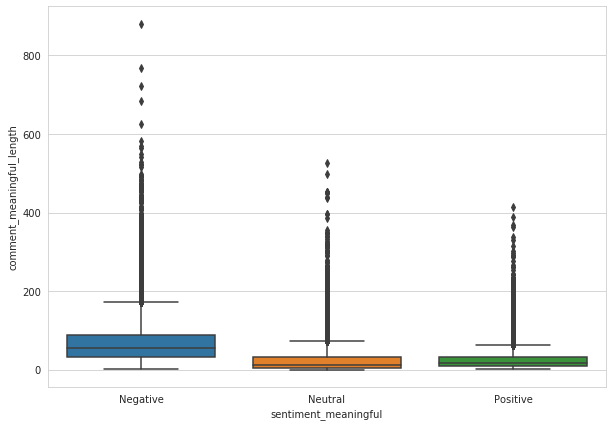

In [30]:
plt.figure(figsize = (10,7))
sns.set_style(style ='whitegrid')
sns.boxplot(data = nyc_reviews, y = 'comment_meaningful_length', x = 'sentiment_meaningful')

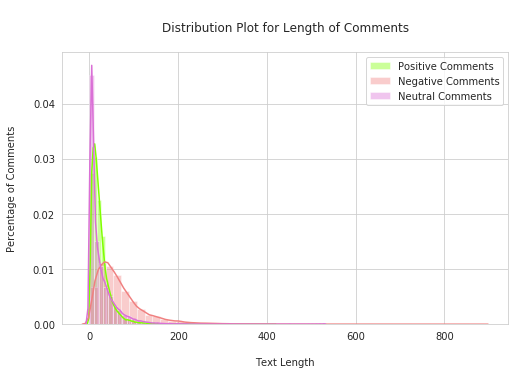

In [47]:
sns.set_style("whitegrid")
plt.figure(figsize=(8,5))

sns.distplot((nyc_reviews[nyc_reviews['sentiment_meaningful']=='Positive']['comment_meaningful_length']), kde=True, bins=50, color='chartreuse')
sns.distplot((nyc_reviews[nyc_reviews['sentiment_meaningful']=='Negative']['comment_meaningful_length']), kde=True, bins=50, color='lightcoral')
sns.distplot((nyc_reviews[nyc_reviews['sentiment_meaningful']=='Neutral']['comment_meaningful_length']), kde=True, bins=50, color='orchid')

plt.title('\nDistribution Plot for Length of Comments\n')
plt.legend(['Positive Comments', 'Negative Comments', 'Neutral Comments'])
plt.xlabel('\nText Length')
plt.ylabel('Percentage of Comments\n');

The mode for the text length of negative comments can be found more to the right than for the positive and neutral comments, which means most of the negative comments are longer than most of the positive or neutral comments. But the tail for positive comments is thicker.

## Word Calculation

In [60]:
review_word = []
for sentence in nyc_reviews.comments_meaningful:
    review_word.extend(sentence.split())

set_review_word_len = len(set(review_word))
overall = [set_review_word_len/len(review_word),
           set_review_word_len,
           len(review_word),
           len(review_word)/len(nyc_reviews)]

In [61]:
word = []
lexicon = []
average_sentence = []
total_word = []
unique_word = []

for i in ['Neutral', 'Positive', 'Negative']:
               nyc_reviews[nyc_reviews['sentiment_meaningful'] == i]['comments_meaningful'].apply(lambda x: word.extend(x.split()))
               lexicon.append(len(set(word))/len(word))
               total_word.append(len(word))
               average_sentence.append(len(word)/len(nyc_reviews[nyc_reviews['sentiment_meaningful'] == i]))
               unique_word.append(len(set(word))) 
               word = []

In [62]:
word_calculation = pd.concat([pd.Series(lexicon),
                              pd.Series(unique_word),
                              pd.Series(total_word), 
                              pd.Series(average_sentence)], axis =1)

In [63]:
word_calculation = pd.concat([word_calculation, pd.DataFrame(overall).transpose()])

In [64]:
word_calculation.index = ['Neutral', 'Positive', 'Negative', 'Overall']
word_calculation.columns = ['Lexicon Diversity',
                            'Unique Word',
                            'Total Word Count',
                            'Average Sentence']
word_calculation

,Lexicon Diversity,Unique Word,Total Word Count,Average Sentence
Neutral,0.062111,60400.0,972445.0,24.321462
Positive,0.028053,27418.0,977381.0,24.426586
Negative,0.041833,72551.0,1734282.0,67.801009
Overall,0.030467,112243.0,3684108.0,34.895648


## Analyze with Word2Vec

The basic idea is that semantic vectors (such as the ones provided by Word2Vec) should preserve most of the relevant information about a text while having relatively low dimensionality which allows better machine learning treatment than straight one-hot encoding of words. Another advantage of topic models is that they are unsupervised so they can help when labaled data is scarce.

Now that we explored our data, this function will turn it into a matrix for our analysis by using the Word2Vec.

In [74]:
# Explore the trained model
model_w2v = Word2Vec.load('w2v_train_model_balance')

### Compress the word vectors into 2D space and plot them with t-SNE

t-Distributed Stochastic Neighbor Embedding (t-SNE) is an unsupervised, non-linear technique primarily used for data exploration and visualizing high-dimensional data. In simpler terms, t-SNE gives you a feel or intuition of how the data is arranged in a high-dimensional space. The t-SNE algorithm calculates a similarity measure between pairs of instances in the high dimensional space and in the low dimensional space. It then tries to optimize these two similarity measures using a cost function.

In [86]:
len(model_w2v.wv.syn0)

10981

In [146]:
# defining the chart
output_notebook()
plot_tfidf = bp.figure(plot_width=700, plot_height=600, title="A map of 10000 word vectors",
    tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
    x_axis_type=None, y_axis_type=None, min_border=1)

# getting a list of word vectors. limit to 10000. each is of 200 dimensions
word_vectors = [model_w2v[w] for w in model_w2v.wv.vocab.keys()]

# dimensionality reduction. converting the vectors to 2d vectors
tsne_model = TSNE(n_components=2, verbose=1, random_state=0)
tsne_w2v = tsne_model.fit_transform(word_vectors)

# putting everything in a dataframe
tsne_df = pd.DataFrame(tsne_w2v, columns=['x', 'y'])
tsne_df['words'] = model_w2v.wv.vocab.keys()

# plotting. the corresponding word appears when you hover on the data point.
plot_tfidf.scatter(x='x', y='y', source=tsne_df)
hover = plot_tfidf.select(dict(type=HoverTool))
hover.tooltips={"word": "@words"}
show(plot_tfidf)

Loading BokehJS ...

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10981 samples in 0.317s...
[t-SNE] Computed neighbors for 10981 samples in 60.794s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10981
[t-SNE] Computed conditional probabilities for sample 2000 / 10981
[t-SNE] Computed conditional probabilities for sample 3000 / 10981
[t-SNE] Computed conditional probabilities for sample 4000 / 10981
[t-SNE] Computed conditional probabilities for sample 5000 / 10981
[t-SNE] Computed conditional probabilities for sample 6000 / 10981
[t-SNE] Computed conditional probabilities for sample 7000 / 10981
[t-SNE] Computed conditional probabilities for sample 8000 / 10981
[t-SNE] Computed conditional probabilities for sample 9000 / 10981
[t-SNE] Computed conditional probabilities for sample 10000 / 10981
[t-SNE] Computed conditional probabilities for sample 10981 / 10981
[t-SNE] Mean sigma: 0.280842
[t-SNE] KL divergence after 250 iterations with early exaggeration: 83.435692
[t-SNE] KL

### Explore semantic similarities between word¶

Words closest to the given word

In [153]:
model_w2v.wv.most_similar("cancel")

[('cancellation', 0.5150265693664551),
 ('confirm', 0.4770665764808655),
 ('extend', 0.4632043242454529),
 ('accept', 0.45655351877212524),
 ('approve', 0.41464197635650635),
 ('refund', 0.41436344385147095),
 ('unreachable', 0.412227600812912),
 ('change', 0.40465736389160156),
 ('unable', 0.39458662271499634),
 ('unresponsive', 0.3872157037258148)]

In [154]:
model_w2v.wv.most_similar("book")

[('stay', 0.6220763921737671),
 ('not', 0.48467493057250977),
 ('booking', 0.48234280943870544),
 ('rent', 0.4701707363128662),
 ('rebook', 0.43015140295028687),
 ('come', 0.4298872947692871),
 ('pay', 0.4227772653102875),
 ('recommend', 0.41554808616638184),
 ('think', 0.4089992046356201),
 ('return', 0.4076690971851349)]

In [155]:
model_w2v.wv.most_similar("host")

[('hostess', 0.6051396727561951),
 ('owner', 0.5595722198486328),
 ('stay', 0.5250556468963623),
 ('landlord', 0.4962245523929596),
 ('not', 0.48784276843070984),
 ('extremely', 0.47499898076057434),
 ('person', 0.4630880355834961),
 ('place', 0.46134090423583984),
 ('need', 0.45435014367103577),
 ('help', 0.4464545249938965)]

In [156]:
model_w2v.wv.doesnt_match("bathroom kitchen bedroom cat".split())

'cat'

In [157]:
def get_word_table(table, key, sim_key = 'similarity', show_sim = True):
    if show_sim == True:
        return pd.DataFrame(table, columns = [key, sim_key])
    else:
        return pd.DataFrame(table, columns = [key, sim_key])[key]

In [158]:
keys = ['host', 'cancel', 'reservation', 'book', 'room', 'clean', 'experience' ];
tables = [];
for key in keys:
    tables.append(get_word_table(model_w2v.wv.similar_by_word(key), key, show_sim=False))

In [159]:
pd.concat(tables, axis=1)

,host,cancel,reservation,book,room,clean,experience
0,hostess,cancellation,booking,stay,bedroom,nice,stay
1,owner,confirm,unreachable,not,space,need,not
2,stay,extend,rebook,booking,bathroom,bed,impression
3,landlord,accept,cancellation,rent,apartment,room,host
4,not,approve,refuse,rebook,not,spotless,place
5,extremely,refund,remainder,come,place,small,attitude
6,person,unreachable,agree,pay,house,great,memory
7,place,change,decide,recommend,bed,good,location
8,need,unable,refund,think,small,kitchen,time
9,help,unresponsive,notify,return,need,not,rating


For now we can comparing the result of The New Sentiment and The Rule based Sentiment

In [63]:
model = pickle.load(open('model_pipeline.pkl', 'rb'))

In [69]:
pred = model.predict(nyc_reviews['comments_meaningful'])

In [76]:
output = pd.DataFrame(data={"listing_id":nyc_reviews["listing_id"], "sentiment":pred})

In [ ]:
result = pd.concat(nyc_reviews, output)

This output by rule based analysis

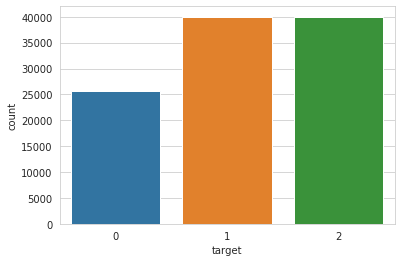

In [92]:
sns.countplot(nyc_reviews['target'], data = nyc_reviews)

And this below by random forest classification

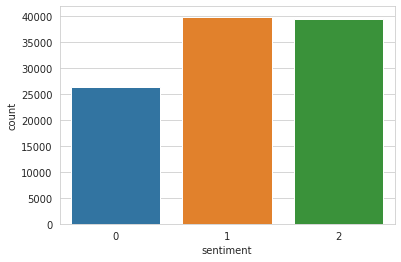

In [90]:
sns.countplot(output['sentiment'], data = output)